### Group Members
- Yael Dahari
- Arbel Tepper

## About the Dataset

The [dataset](https://www.kaggle.com/competitions/playground-series-s4e9/data) used in this project was generated from a deep learning model trained on the [Used Car Price Prediction Dataset](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset). While the feature distributions are close to, but not exactly the same as the original, it provides valuable insights into the world of automobiles. 

This dataset comprises 188,534 data points, each representing a unique vehicle listing. It includes **twelve** distinct features that offer a comprehensive view of key factors in the automotive industry. The attributes are as follows:

- **Brand**: The brand or company name of the vehicle.
- **Model**: The specific model of the vehicle.
- **Model Year**: The manufacturing year of the vehicle, important for assessing depreciation and technological advancements.
- **Mileage**: The mileage of each vehicle, indicating wear and tear and potential maintenance needs.
- **Fuel Type**: The type of fuel the vehicle uses, such as gasoline, diesel, electric, or hybrid.
- **Engine Type**: The specifications of the engine, which influence performance and efficiency.
- **Transmission**: The transmission type, such as automatic, manual, or other variations.
- **Exterior & Interior Colors**: The aesthetic aspects of the vehicle, including the options for both exterior and interior colors.
- **Accident History**: Whether the vehicle has a history of accidents or damage, crucial for assessing its condition.
- **Clean Title**: Indicates whether the vehicle has a clean title, which affects resale value and legal status.
- **Price**: The listed price of the vehicle, which is essential for price comparison and budgeting.

This dataset serves as a valuable resource for automotive enthusiasts, buyers, and researchers interested in analyzing trends, making informed purchasing decisions, or conducting studies related to the automotive industry and consumer preferences. Whether you are a data analyst, car buyer, or researcher, this dataset offers a wealth of information for further exploration and analysis.

# 0. Imports

Loading the necessary libraries we'll need for our project, and the dataset we're working on.

In [30]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

import shap

In [31]:
df = pd.read_csv('./playground-series-s4e9/train.csv',index_col='id')

df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


### 0.1 Splitting the dataset to a train dataset and test dataset

80% of the data is assigned to the training set and 20% to the test set.

In [32]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size

df_train, df_test = df.iloc[:train_size], df.iloc[test_size:]

# 1. Column Transformations

After reviewing the dataset, we decided to apply several transformations to the attributes in order to prepare the data for later use in a linear regression model.

## 1.1 Engine Transformer

The original `engine` attribute was a string containing the **horse power**, **number of cylinders**, and **tank size** in liters. Since this information is crucial for our analysis, we extracted these three features using regex (as the string followed a specific format) and created separate numerical columns for each.  
Afterward, the original `engine` attribute was dropped, as it was no longer needed.

In [33]:
# Extracting the horse power, tank size and number of cylinders means from the train dataset engine column
# so that we can use them to fill the missing values in the test dataset

df_train_copy = df_train.copy()

df_train_copy['horse_power'] = df_train_copy['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
df_train_copy['tank_size'] = df_train_copy['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
df_train_copy['num_cylinders'] = df_train_copy['engine'].str.extract(r'(\d+)\sCylinder').astype(float) 
	

train_hp_mean = df_train_copy['horse_power'].mean()
train_tank_size_mean = df_train_copy['tank_size'].mean()
train_num_cylinders_mean = df_train_copy['num_cylinders'].mean()

In [34]:
def EngineTransformer(X):
	X = X.copy()

	X['horse_power'] = X['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
	X['tank_size'] = X['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
	X['num_cylinders'] = X['engine'].str.extract(r'(\d+)\sCylinder').astype(float) 
	   
	# Drop the original 'engine' column
	X.drop('engine', axis=1, inplace=True)
	return X

## 1.2 Transmission Transformer
The `transmission` attribute contained an unformatted string. We used regex to identify the relevant keywords and created three binary columns: `automatic`, `dual`, and `manual`.  
Each car can have only one of these attributes set to `True`.  
We decided to separate the `dual` category instead of marking both `automatic` and `manual` as `True` because it might carry unique signals that we want to capture.


In [35]:
def TransmissionTransformer(X):
    # Initialize all attributes to False
    X = X.copy()

    X['automatic'] = False
    X['manual'] = False
    X['dual'] = False
    
    # Categorize as 'dual' if it contains 'Dual'
    X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
    
    # Ensure 'dual' is boolean before using ~ operator
    X['dual'] = X['dual'].astype(bool)
    # Categorize as 'automatic' if it contains AT, A/T, CVT, or Automatic (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
    # Categorize as 'manual' if it contains MT, M/T, or Manual (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True

    # Drop the original 'transmission' column
    X.drop('transmission', axis=1, inplace=True)

    # Move the target column to the end, in case X is the test set there is no target column
    cols = X.columns.tolist()
    if "price" in cols:
        cols.append(cols.pop(cols.index('price')))
        X = X[cols]
    
    return X

## 1.3 Color Transformer
We analyzed the `int_color` and `ext_color` attributes and decided to keep only the top 12 colors (based on value counts). The remaining colors were grouped into an "other" category.  
This way, we can maintain a reasonable number of color categories and transform them into a one-hot encoded vector.

In [36]:
def ColorTransformer(X):
	X = X.copy()
	# Colors to keep (top 12) - using df_train_train_train_train and not X to avoid data leakage when X is the test set.
	ext_colors = list(df_train["ext_col"].value_counts()[:12].index)
	int_colors = list(df_train["int_col"].value_counts()[:12].index)
	int_colors.remove("–")
	# Categorize as 'other' if not in the top 12 colors
	X.loc[~X['ext_col'].isin(ext_colors), 'ext_col'] = 'other'
	X.loc[~X['int_col'].isin(int_colors), 'int_col'] = 'other'
	
	return X

## 1.4 Brand Transformer
Similarly to the `color` attribute, we applied the same approach to the `brand` column, but this time we kept the top 24 brands due to their potential significance. Brands outside the top 24 were grouped into an "other" category.

In [37]:
def BrandTransformer(X):
	X = X.copy()
	# Brands to keep (top 24)
	brands = list(df_train["brand"].value_counts()[:24].index)
	# Categorize as 'other' if not in the top 24 brands
	X.loc[~X['brand'].isin(brands), 'brand'] = 'other'
	
	return X

## 1.5 Clean Title Transformer
For the `clean_title` attribute, we replaced the string "Yes" with a boolean `True`, simplifying the column for modeling purposes.

In [38]:
def CleanTitleTransformer(X):
    X = X.copy()
    # Change the "Yes" to the boolean True
    X['clean_title'] = X['clean_title'].replace('Yes', True)
    
    return X

## 1.6 Accident Transformer
The `accident` attribute contained string values such as "None reported" and "At least 1 accident or damage reported."  
We transformed these into boolean values, setting "None reported" to `True` and "At least 1 accident or damage reported" to `False`.

In [39]:
def AccidentTransformer(X):
	X = X.copy()
	# Change the "None reported" to the boolean True and At least 1 accident or damage reported to False
	X['accident'] = X['accident'].replace('None reported', False)
	X['accident'] = X['accident'].replace('At least 1 accident or damage reported', True)
	
	return X

The Drop Irrelevant Columns function drops the inly column which we find irrelevant - the model name.

In [40]:
def DropIrrelevantColumns(X):
	X = X.copy()
	X = X.drop(columns=['model'])

	return X

This is the final function that applies all the transformers on the dataset to create the necessary effects.

In [41]:
def ColumnTransformer(X):
    X = EngineTransformer(X)
    X = TransmissionTransformer(X)
    X = ColorTransformer(X)
    X = BrandTransformer(X)
    X = CleanTitleTransformer(X)
    X = AccidentTransformer(X)
    X = DropIrrelevantColumns(X)
    
    return X

Now, let's apply the column trannsformation on our dataset:

In [42]:
df_train_transformed = df_train.copy()
df_train_transformed = ColumnTransformer(df_train_transformed)
df_train_transformed.head()

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True


,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,False,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,True,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,False,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,False,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,False,True,208.0,2.0,4.0,True,False,False,97500


# 2. Filling Null Values

After transforming the columns, we examined the dataset to determine how many null values remain. Here is a summary of the columns with null values:

- `fuel_type`: 2.7% null values
- `accident`: 1.3% null values
- `clean_title`: 11.36% null values
- `horse_power`: 17.64% null values
- `tank_size`: 7.53% null values
- `number_of_cylinders`: 20% null values

In [43]:
df_train_transformed.isna().sum()

brand                0
model_year           0
milage               0
fuel_type         4059
ext_col              0
int_col              0
accident          1983
clean_title      17229
horse_power      26584
tank_size        11339
num_cylinders    30250
automatic            0
manual               0
dual                 0
price                0
dtype: int64

## Strategies for Handling Nulls

In general, we have two main options for dealing with null values:
1. Drop the entries containing null values and train the model without them.
2. Replace the null values with a substitute value.

Since the `fuel_type` and `accident` attributes have a small percentage of null values, we can drop these rows without losing significant data. However, the remaining attributes (`clean_title`, `horse_power`, `tank_size`, and `number_of_cylinders`) have a more considerable percentage of missing data, so dropping these rows would result in a substantial loss of information. As such, we decided to fill the null values for all attributes. We may revisit this decision based on the model's performance.

### How We Are Filling Each Attribute:

- **`fuel_type`**: We replaced the null values (and entries with '-') with "Gasoline", as this is the most common fuel type in the dataset (and most cars use gasoline).

- **`accident`**: We filled the null values with `False`, assuming that if no accident was reported, the car has not been in an accident. This approach is a bit simplistic, but we may adjust it later to represent "unknown" accidents with `-1` based on model performance.

- **`clean_title`**: This column only had `True` and `null` values, so we replaced all nulls with `False`.

- **`horse_power`, `tank_size`, and `number_of_cylinders`**: We filled the missing values with the average value of each attribute in the training dataset, rounded to the nearest integer.

In [44]:
def Imputer(X):
	X = X.copy()
	
	X["fuel_type"] = X["fuel_type"].replace('not supported', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace('–', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace(pd.NA, "Gasoline")

	X['accident'] = X['accident'].fillna(False)

	X['clean_title'] = X['clean_title'].fillna(False)

	# Using the mean of the training set to fill the missing values, to avoid data leakage when X is the test set.
	X['horse_power'] = X['horse_power'].fillna(round(train_hp_mean))

	X['tank_size'] = X['tank_size'].fillna(round(train_tank_size_mean))

	X['num_cylinders'] = X['num_cylinders'].fillna(round(train_num_cylinders_mean))
	
	return X

# I. Applying the Preprocessing steps

In [45]:
def preprocessor(X):
    X = ColumnTransformer(X)
    X = Imputer(X)
    
    return X

In [46]:
df_train_preprocessed = preprocessor(df_train)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
C:\Users\Yael Dahari\AppData\Local\Tem

In [47]:
df_train_preprocessed.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,False,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,True,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,False,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,False,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,False,True,208.0,2.0,4.0,True,False,False,97500


In [48]:
df_train_preprocessed.dtypes

brand             object
model_year         int64
milage             int64
fuel_type         object
ext_col           object
int_col           object
accident            bool
clean_title         bool
horse_power      float64
tank_size        float64
num_cylinders    float64
automatic           bool
manual              bool
dual                bool
price              int64
dtype: object

# 3. Visualizing Relationships Between Attributes and Price

In this presentation, we aim to explore five compelling visualizations that uncover interesting relationships between various car attributes and their impact on price. By analyzing these connections, we seek to gain deeper insights into how factors such as engine characteristics, fuel type, and brand influence a car's market value. These visualizations are designed to highlight patterns, trends, and potential correlations, providing valuable perspectives on the dataset and its attributes.

### 3.1 Engine Attributes vs. Price

This visualization highlights the relationship between three key engine attributes - horsepower, number of cylinders, and fuel tank size - and their impact on a car's price.

By transforming the price to a logarithmic scale, we account for the skewness in the distribution, allowing for a clearer analysis of trends across different price ranges.

Conclusions:

- From this plot, we observe that as horsepower and the number of cylinders increase, the price tends to rise as well, indicating that more powerful or complex engines generally correlate with higher-priced vehicles.

- However, we notice that the fuel tank size does not show a clear correlation with price. This suggests that while engine performance (horsepower and cylinders) plays a significant role in determining price, the fuel tank size might not be a major factor.


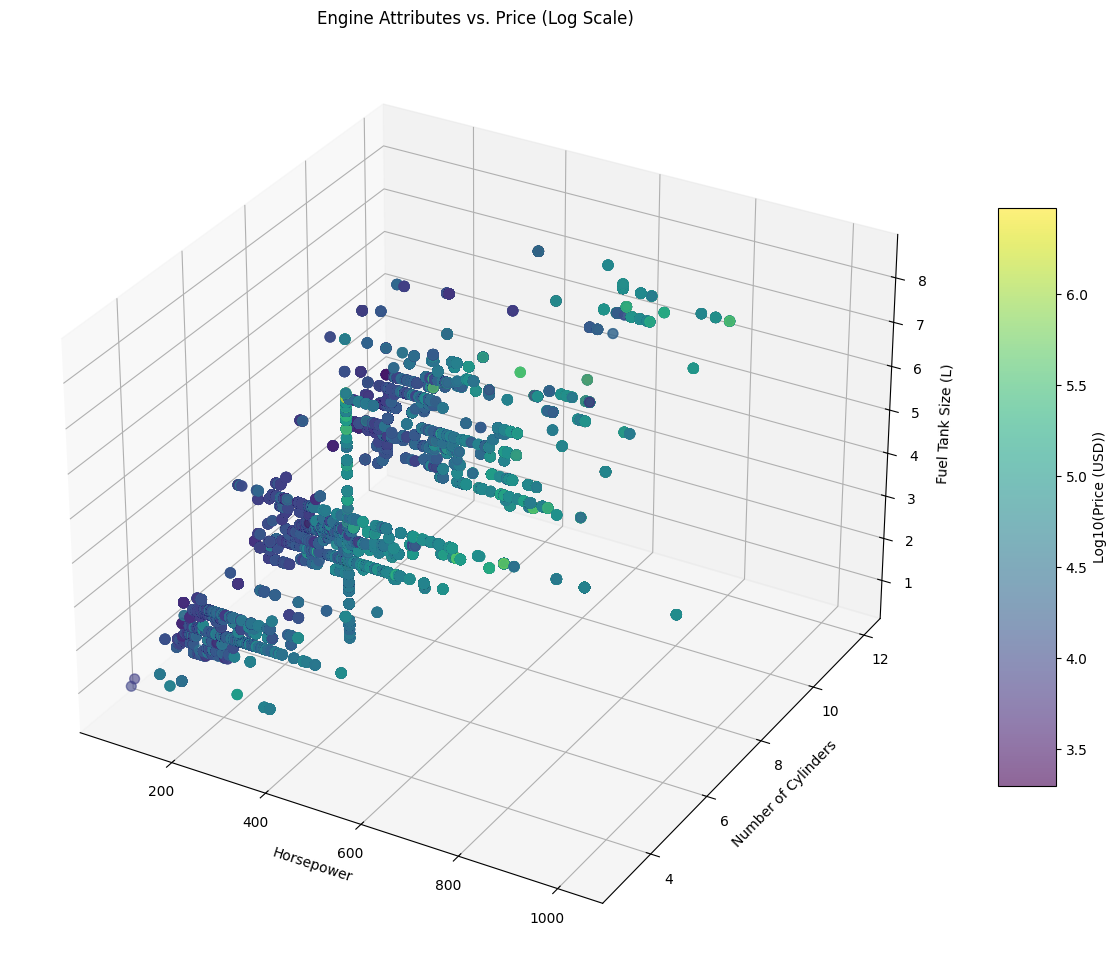

In [49]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

prices_log = np.log10(df_train_preprocessed['price'])

# Scatter plot
sc = ax.scatter(df_train_preprocessed['horse_power'], df_train_preprocessed['num_cylinders'],
				df_train_preprocessed['tank_size'], c=prices_log,
				cmap='viridis', s=50, alpha=0.6)

# Add labels and title
ax.set_title('Engine Attributes vs. Price (Log Scale)')
ax.set_xlabel('Horsepower')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Fuel Tank Size (L)')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Log10(Price (USD))')

plt.show()


### 3.2 Correlation Heatmap Between All Numerical Attributes

This heatmap provides a visual representation of the correlation between the numerical attributes in our dataset. It is particularly useful for identifying relationships that might not be immediately obvious, allowing us to focus on key variables that influence the price.

We can observe several interesting trends:

- **Model year and mileage** are strongly negatively correlated, which makes sense as newer cars generally have fewer miles driven. This is a typical pattern in used car datasets.

- **Tank size and number of cylinders** exhibit a very strong positive correlation. This suggests that cars with larger engines (more cylinders) tend to have bigger fuel tanks, which is an expected relationship given the design of larger vehicles.

- **Horsepower and number of cylinders** also show a positive correlation, reflecting the fact that cars with more cylinders generally have greater horsepower.

The attributes with the **highest correlation** to price are:

- **Mileage** (-0.28): The negative correlation indicates that as mileage increases, the price tends to decrease, which is a common observation for used cars.

- **Model year** (0.23): A positive correlation with price is expected, as newer models generally command higher prices.

- **Horsepower** (0.21): A positive correlation with price is expected, as stronger engines generally command higher prices.

Understanding these correlations is key to forming insights about which features are most important in determining the car's price. This can guide further analysis, including predictive modeling or targeted marketing strategies.

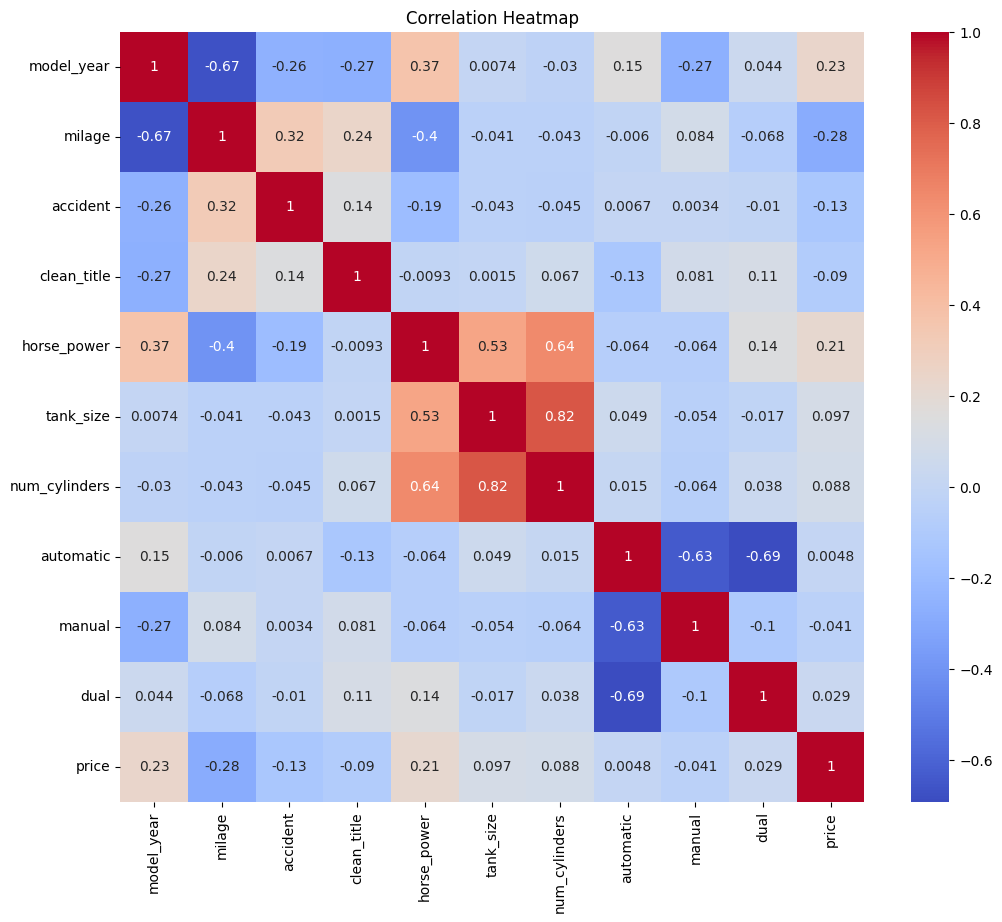

In [50]:
fig, ax = plt.subplots(figsize=(12,10))

numerical_cols = df_train_preprocessed.dtypes[(df_train_preprocessed.dtypes=="float64") | (df_train_preprocessed.dtypes=="int64") | (df_train_preprocessed.dtypes=="bool")].index.tolist()

corr_matrix = df_train_preprocessed[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

### 3.3 Average Price by Fuel Type and Brand

This bar chart visualizes the average price of cars based on fuel type and brand. A few interesting trends can be observed:

- **E85 Flex Fuel** has the lowest average prices across almost all brands. However, **Kia** stands out as an exception, with **E85 Flex Fuel** having the highest average price among all fuel types in the dataset.

- **Porsche** and **Mercedes-Benz** consistently show high average prices across the fuel types of **Gasoline**, **Hybrid**, and **Plug-In Hybrid**, which aligns with their status as luxury brands known for higher-priced vehicles.

- **Cadillac** and **Jeep** have particularly high average prices for the **Diesel** fuel type, which could be due to the types of vehicles (e.g., SUVs, trucks) they tend to produce, often at higher price points.

- **Tesla** does not exhibit a distinctly higher average price in any of the fuel types, which may be surprising given its premium electric vehicles. This suggests that Tesla’s pricing is not as dependent on fuel type but may be influenced by other factors.

- **Acura**, **Hyundai**, **Nissan**, **Mazda**, and **Subaru** are missing from several fuel types, which may indicate a limited variety of vehicles within those fuel types. This could impact the model’s ability to make accurate price predictions for these brands in specific fuel categories.

This graph is useful for understanding how the combination of fuel type and brand impacts the price of a car. By examining these trends, we can infer which brands tend to have higher or lower prices for specific fuel types and assess how well a model might predict car prices based on these factors.

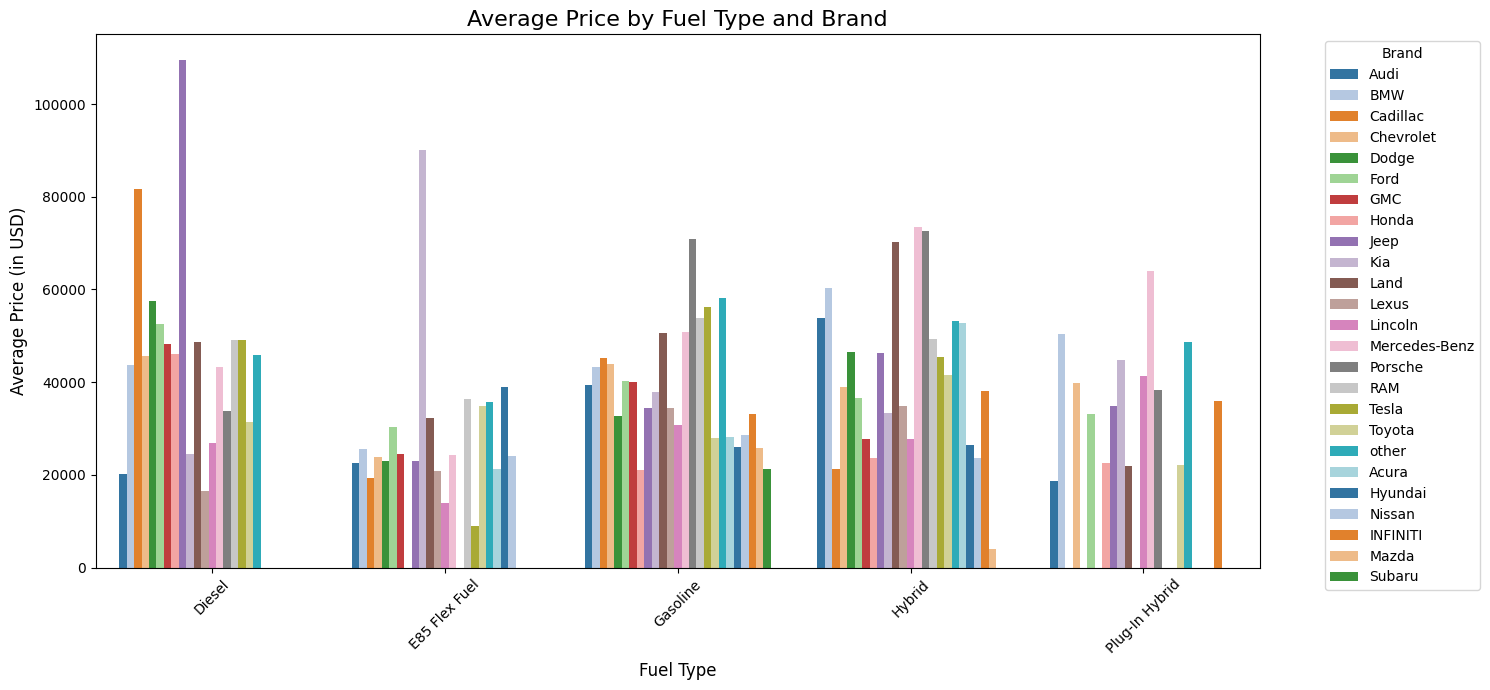

In [51]:
# Compute the average price grouped by fuel type and brand
avg_price_by_fuel_and_brand = (
    df_train_preprocessed.groupby(['fuel_type', 'brand'])['price']
    .mean()
    .reset_index()
)

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Create a grouped bar chart
sns.barplot(
    data=avg_price_by_fuel_and_brand, 
    x='fuel_type', 
    y='price', 
    hue='brand', 
    ax=ax, 
    palette='tab20'
)

# Add title and labels
plt.title('Average Price by Fuel Type and Brand', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price (in USD)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()

# Show the plot
plt.show()


### 3.4 Average Price by Brand and by Accident History or Clean Title

The heatmaps provide insights into how **accident history** and **clean title** status impact the average price of cars across different brands:

- **Accident History**: As expected, cars that have not been in an accident generally command higher prices compared to those that have been involved in accidents. This aligns with the assumption that accident-free cars are typically in better condition and more desirable on the market.

- **Clean Title**: Surprisingly, cars without a clean title consistently show higher average prices than those with a clean title. This is counterintuitive, as cars with a clean title are usually perceived as more reliable and have higher resale value. This anomaly suggests that there might be an issue with how the clean title attribute is represented in the dataset. It could indicate missing or inconsistent data, which could affect the accuracy of the model's predictions.

Given this inconsistency, further investigation into the dataset is necessary. The model's performance may be impacted by this feature, and we may need to reconsider its inclusion in the analysis or apply an imputation technique to handle missing or anomalous values.

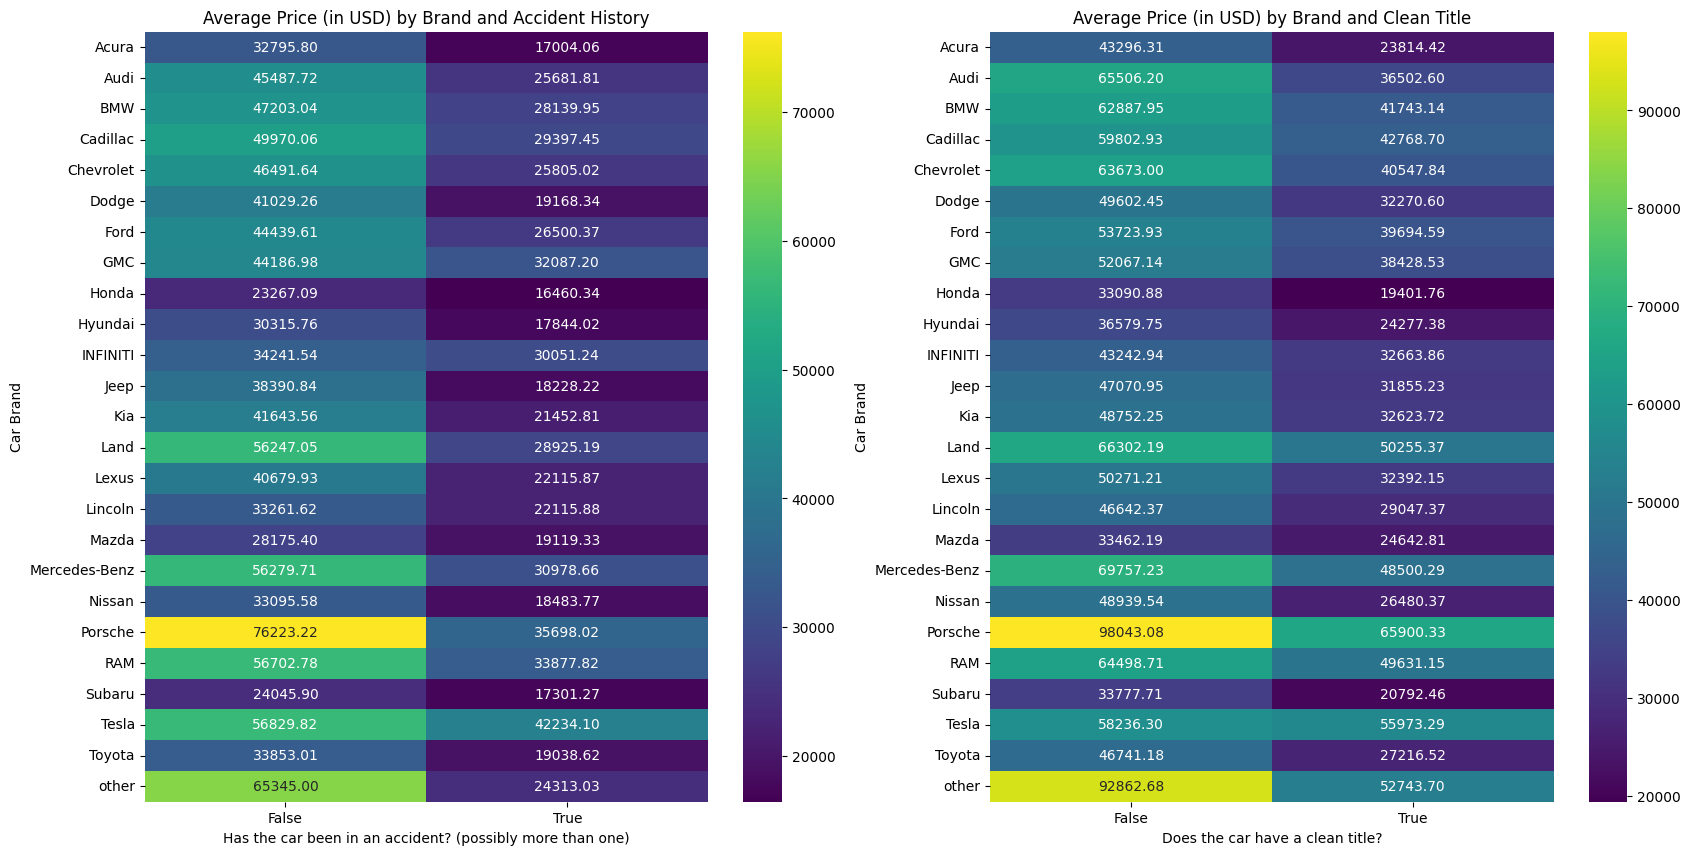

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# The first is the y axis, the second is the x axis
avg_price_by_brand_accident = df_train_preprocessed.groupby(['brand', 'accident'])['price'].mean().unstack()
heatmap1 = sns.heatmap(avg_price_by_brand_accident, annot=True, fmt=".2f", cmap='viridis', ax=ax[0], cbar = True)
ax[0].set_title('Average Price (in USD) by Brand and Accident History')
ax[0].set_xlabel('Has the car been in an accident? (possibly more than one)')
ax[0].set_ylabel('Car Brand')

avg_price_by_brand_clean = df_train_preprocessed.groupby(['brand', 'clean_title'])['price'].mean().unstack()
heatmap2 = sns.heatmap(avg_price_by_brand_clean, annot=True, fmt=".2f", cmap='viridis', ax=ax[1], cbar = True)
ax[1].set_title('Average Price (in USD) by Brand and Clean Title')
ax[1].set_xlabel('Does the car have a clean title?')
ax[1].set_ylabel('Car Brand')

plt.show()

### 3.5 Distribution of Car Prices by Model Year Intervals (Logarithmic Scale)

In this analysis, the car model years are grouped into 5-year intervals, and the distribution of car prices within each interval is visualized using a box plot. The prices are transformed to a logarithmic scale for better comparison across a wide range of values.

Key Observations:
- **1973-1979**: Surprisingly, the median price in this interval is relatively high, which is counterintuitive since older cars are typically expected to have lower prices. This anomaly might indicate the presence of collectible or rare cars from this period, or potentially some outliers that skew the median.

- **Price Trend by Year**: As expected, newer cars (from 1990 onwards) generally have higher median prices, reflecting the increased desirability of newer models due to advancements in technology, features, and overall condition.

- **Inter-Quartile Range**: The distance between the quantiles remains relatively consistent across the intervals, suggesting that the spread of prices within each period is similar. This indicates that the market dynamics and price variations within these intervals have remained relatively stable, with some slight increases in variability as we move toward more recent years.

- **Outliers between 1990 and 2004**: In this period, most of the outliers appear above the maximum value of the box plot, indicating that there are a significant number of cars that are priced much higher than the typical price range for cars in this interval. This could be due to high-end, luxury, or premium cars that stand out in terms of price, with very few cars breaking the upper price boundary of the box plot.

- **Outliers from 2005 onward**: Starting from 2005, while we still observe outliers above the maximum price of the box plot, there is a notable increase in outliers that fall below the minimum price of the box plot. These "smaller" outliers could indicate:

    - A rise in lower-priced cars entering the market, possibly due to more affordable, economy models becoming prevalent.
    - A broader range of vehicle prices, reflecting greater diversity in the car market, with some cars being significantly cheaper (e.g., due to condition, brand value, or used car pricing) while others remain at the higher end of the spectrum.

**Conclusion**:
The box plot analysis reveals several trends in car pricing over time, with some surprising exceptions, particularly in the older car models. The overall upward price trend is consistent with the expectation that newer cars tend to be more expensive. The increase in outliers and slight widening of price distributions from 2005 onwards suggests a growing diversity in the market for cars, possibly due to the rise of new models, electric vehicles, or changing consumer preferences. The consistent inter-quartile range implies that, while prices may fluctuate, the distribution of car prices has remained relatively stable over time.

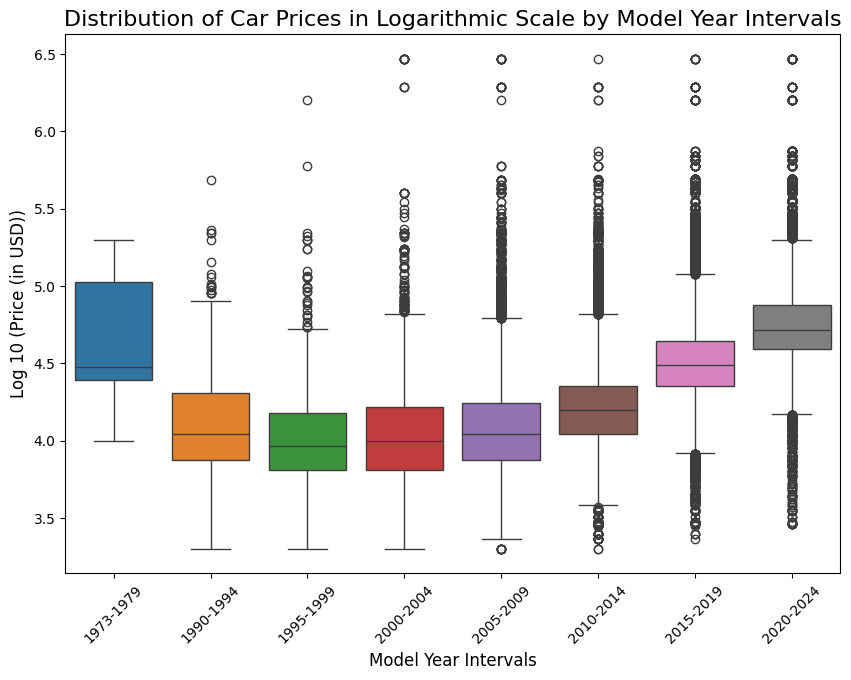

In [53]:
# Define the intervals
bins = [1973, 1980, 1994, 1999, 2004, 2009, 2014, 2019, 2024] 
labels = ["1973-1979", "1990-1994", "1995-1999", "2000-2004", "2005-2009", 
          "2010-2014", "2015-2019", "2020-2024"]

# Add an interval column
df_interval = df_train_preprocessed.copy()
df_interval['year_interval'] = pd.cut(df_interval['model_year'], bins=bins, labels=labels, right=True)

prices_log = np.log10(df_interval['price'])

# Create a box plot
plt.figure(figsize=(10, 7))
sns.boxplot(x='year_interval', y=prices_log, data=df_interval, hue='year_interval', legend=False)

# Add titles and labels
plt.title('Distribution of Car Prices in Logarithmic Scale by Model Year Intervals', fontsize=16)
plt.xlabel('Model Year Intervals', fontsize=12)
plt.ylabel('Log 10 (Price (in USD))', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## II. Applying a One-Hot transformation 

We have the categorical columns: `brand`, `fuel_type`, `ext_col`, `int_col`.

For these columns, we have already retained the most predominant values and grouped the remaining ones under `other`. These columns need to undergo a transformation to be compatible with a linear regression model.

Since none of these columns contain values that exhibit any inherent order, we will employ a **one-hot transformation**. This approach encodes each categorical value as a separate binary feature, where each feature represents the presence (`1`) or absence (`0`) of a specific category in the original column.

The one-hot transformation ensures that the model can interpret the categorical data without imposing any unintended ordinal relationships, making it suitable for training a linear regression model.

In [54]:
def OneHotEncoder(X):
	X = X.copy()
	# One-hot encode the categorical columns
	X = pd.get_dummies(X, drop_first=True)
	
	# Move the target column to the end, in case X is the test set there is no target column
	cols = X.columns.tolist()
	if "price" in cols:
		cols.append(cols.pop(cols.index('price')))
		X = X[cols]

	return X

In [55]:
df_ready = OneHotEncoder(df_train_preprocessed)

df_ready.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,True,False,False,False,False,False,4200
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,False,False,4999
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,13900
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,45000
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,97500


In [56]:
df_ready.columns

Index(['model_year', 'milage', 'accident', 'clean_title', 'horse_power',
       'tank_size', 'num_cylinders', 'automatic', 'manual', 'dual',
       'brand_Audi', 'brand_BMW', 'brand_Cadillac', 'brand_Chevrolet',
       'brand_Dodge', 'brand_Ford', 'brand_GMC', 'brand_Honda',
       'brand_Hyundai', 'brand_INFINITI', 'brand_Jeep', 'brand_Kia',
       'brand_Land', 'brand_Lexus', 'brand_Lincoln', 'brand_Mazda',
       'brand_Mercedes-Benz', 'brand_Nissan', 'brand_Porsche', 'brand_RAM',
       'brand_Subaru', 'brand_Tesla', 'brand_Toyota', 'brand_other',
       'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid',
       'fuel_type_Plug-In Hybrid', 'ext_col_Black', 'ext_col_Blue',
       'ext_col_Brown', 'ext_col_Gold', 'ext_col_Gray', 'ext_col_Green',
       'ext_col_Orange', 'ext_col_Red', 'ext_col_Silver', 'ext_col_White',
       'ext_col_Yellow', 'ext_col_other', 'int_col_Black', 'int_col_Blue',
       'int_col_Brown', 'int_col_Ebony', 'int_col_Global Black',
       'in

# 4. Regression Model and Error Analysis

## III. Appying the Complete Dataframe Manipulation Pipeline

With all transformations applied, the dataframe is now fully prepared to be used as input for a Linear Regression Machine Learning Model.

In [57]:
def pipeline(X):
	X = preprocessor(X)
	X = Imputer(X)
	X = OneHotEncoder(X)
	
	y = X['price']
	X = X.drop(columns=['price'])
	
	return X, y

### 4.1 Regression Model

We chose the basic Linear Regression model from sci-kit learn. 

In [58]:
X_train, y_train = pipeline(df_train)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
C:\Users\Yael Dahari\AppData\Local\Tem

LinearRegression()

In [59]:
X_test, y_test = pipeline(df_test)

y_pred = linear_reg.predict(X_test)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_23480\131134169.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
C:\Users\Yael Dahari\AppData\Local\Tem

### 4.2 Error Analysis

Analyzing the model's performance is a crucial step in understanding how well it predicts the target variable and identifying areas for improvement. Key aspects of error analysis include:

- **Residual Analysis**: Examining the differences between the actual and predicted values (residuals) to identify patterns. Ideally, residuals should be randomly distributed, indicating that the model captures the underlying data trends.

- **Relative Errors**: Evaluating the magnitude of errors relative to the actual values helps identify instances where the model underperforms, such as outliers or specific data segments.

- **Feature Contribution**: Using tools like SHAP or feature importance scores to assess how each feature contributes to predictions. This can help detect if the model relies too heavily on certain attributes or ignores others.

- **Error Distribution**: Visualizing error distributions can highlight whether the model performs better on certain ranges of data, such as lower or higher price points.

Performing thorough error analysis allows us to refine the model, adjust preprocessing steps, or revisit feature engineering to improve its predictive accuracy.

#### 4.2.1 Understanding R² Score

The R² score, also known as the coefficient of determination, measures the proportion of the variance in the target variable that is explained by the model. It ranges from 0 to 1:

- **R² = 1**: The model perfectly predicts the target variable.

- **R² = 0**: The model does not explain any variance and performs as poorly as predicting the mean of the target variable.

- **Negative R²**: The model performs worse than simply predicting the mean.

In our case, we achieved an **R² score of 0.106**. This means that the model explains only about 10.6% of the variance in the target variable, indicating that it has limited predictive power. Several factors could contribute to this low score:

- **Insufficient features**: The features used may not fully capture the factors influencing the target variable.

- **Feature engineering**: Important transformations or interactions between features may be missing.

- **Model limitations**: Linear regression may not be the best fit for the dataset if the relationships between features and the target are non-linear.

This low R² score suggests that there is significant room for improvement. Potential next steps include exploring additional features, applying non-linear models, or fine-tuning the current pipeline to enhance performance.

In [60]:
r2_score(y_test,y_pred)

0.10637623834770804

#### 4.2.2 Error Metrics

To further evaluate the model’s performance, we calculated the following error metrics:

- **Mean Absolute Percentage Error (MAPE): 75.7%**

    This indicates that, on average, the model's predictions deviate from the actual values by 75.7%. A high MAPE suggests significant inaccuracies in the model’s predictions.

- **Mean Absolute Error (MAE): 22,882**

    This represents the average absolute difference between the predicted and actual values. In this case, the average error is approximately 22,882 USD, which is substantial relative to typical car prices.

- **Root Mean Squared Error (RMSE): 74,817**

    RMSE penalizes larger errors more than MAE and highlights how far off the predictions can be. An RMSE of 74,817 USD suggests that the model occasionally makes extremely large errors.

- **Max Error: 2,950,944 USD**

    The maximum absolute error in predictions is nearly 3 million USD, occurring at index 92612. This extreme value likely represents an outlier or a case where the model performs exceptionally poorly.

**Conclusions:**

The error metrics indicate that the model's performance is far from ideal. The high MAPE and substantial RMSE suggest that the model struggles to generalize well across the dataset. The extremely high max error highlights the presence of significant outliers or instances where the model fails to capture key factors influencing price.

To improve these metrics, we may need to:

- Perform additional feature engineering.

- Handle outliers more effectively.

- Explore non-linear or more robust models that can better capture complex relationships in the data.

In [61]:
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):,.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")

# residuals
residuals = y_test - y_pred
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]

Mean Absolute Percentage Error: 0.757
Mean Absolute Error: 22,882
Root Mean Squared Error: 74,817


#### 4.2.3 Residuals Analysis: Absolute vs Percentage

1. **Residuals (Abs) Plot**:
    - **Most Points Clustered Around Lower Residuals**: The majority of the residuals are concentrated within the range of [0, 0.5] million USD. This indicates that, for most predictions, the model's error is relatively large, with residuals showing a noticeable discrepancy between predicted and actual values.
    - **Outliers at Higher Predicted Values**: As predicted values increase, the residuals also tend to increase, highlighting that the model struggles with higher predicted values. This could point to a significant error in predictions for extreme or rare cases.
    - **Weak Correlation**: The data points in the scatter plot seem to show a weak correlation between the predicted and actual values. The points are scattered widely, particularly at lower predicted values, and there is no clear linear pattern suggesting that the model’s predictions are highly accurate.

2. **Residuals (%) Plot**:
    - **Negative Predictions Leading to Positive Percentages**: When the predicted values are negative, the residual percentage becomes positive, with the error growing as the predicted value becomes more negative. This shows that the model has difficulty predicting negative values, leading to high positive residual percentages.
    - **Large Negative Percentage for Positive Predictions**: A significant negative residual percentage is observed when the model predicts positive values, with the largest absolute percentage of -30% seen for a predicted value around 800,000 USD. This indicates that the model's prediction for positive values is consistently off by a substantial margin, leading to large errors in relative terms.

**Conclusion:**  
Overall, the model's performance requires significant improvement. The large residuals in absolute terms and the extreme negative percentage residuals suggest that the model is not effectively predicting either low or high values. The residuals analysis clearly points to a need for further model refinement, including better handling of outliers, negative predictions, and high-value predictions.

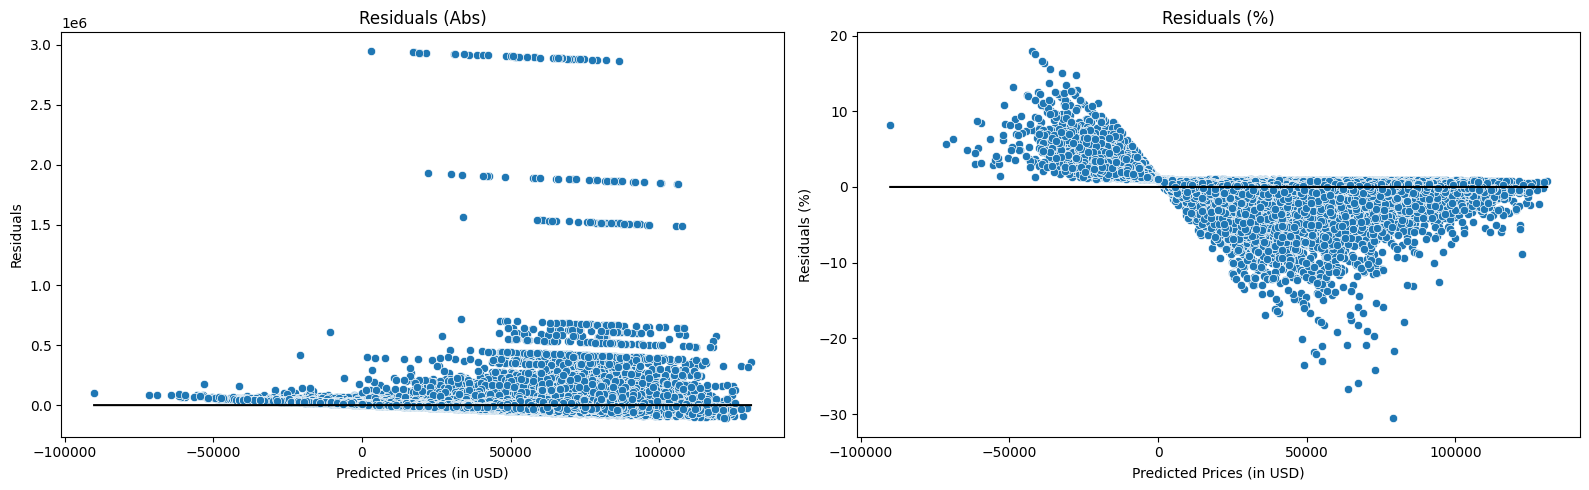

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot for absolute residuals
sns.scatterplot(x=y_pred, y=residuals, ax=ax[0])
sns.lineplot(x=y_pred, y=[0]*len(y_pred), ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Prices (in USD)")
ax[0].set_ylabel("Residuals")

# Plot for percentage residuals
sns.scatterplot(x=y_pred, y=residuals/y_test, ax=ax[1])
sns.lineplot(x=y_pred, y=[0]*len(y_pred), ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Prices (in USD)")
ax[1].set_ylabel("Residuals (%)")

plt.tight_layout()
plt.show()

#### 4.2.4 Residuals Histogram Analysis

The residuals histogram reveals important insights into how well our model is performing:

- **Skewed Distribution**: The histogram shows a highly skewed distribution, with a majority of the residuals clustered near 0 and a few outliers with large values. This suggests that the model has small errors for most predictions but struggles significantly for a small subset of cases, resulting in large residuals.

- **Bias in Predictions**: The fact that most residuals are near zero indicates that the model is generally close to the actual values. However, the large residuals observed suggest that there is a potential bias in the predictions. The model may be underpredicting or overpredicting certain values, particularly for extreme cases.

- **Presence of Outliers**: The extreme residuals, especially the long tail towards higher values, indicate the presence of outliers or large deviations in predictions for some data points. These outliers may be due to data issues or limitations in the model's capacity to handle extreme cases.

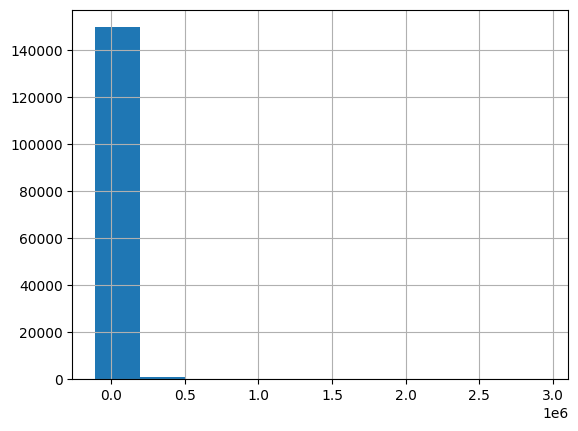

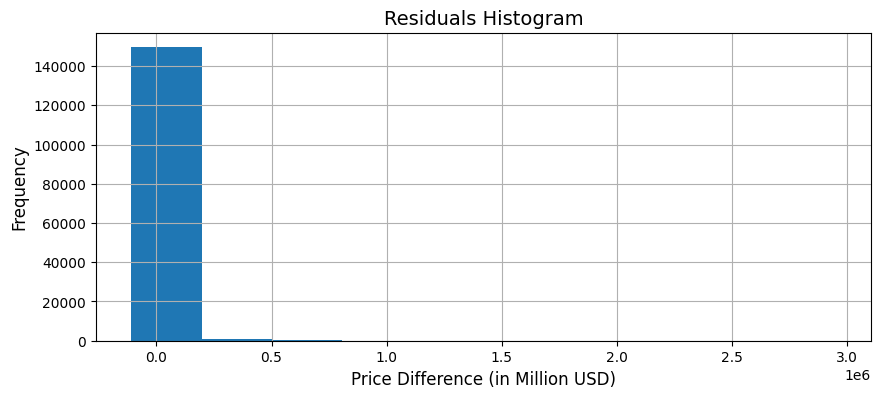

In [63]:
residuals.hist()
fig, ax = plt.subplots(figsize=(10,4))
residuals.hist(ax=ax)
ax.set_title('Residuals Histogram', fontsize=14)
ax.set_xlabel('Price Difference (in Million USD)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

#### 4.2.5 Model Performance Overview

- **Percentage of Predictions with Less than 5% Error**: Only **6.33%** of the predictions have an error margin of less than 5%, indicating that the model is frequently making substantial errors in its predictions.

- **Percentage of Predictions with More than 20% Error**: A significant **75.36%** of predictions exhibit an error greater than 20%, highlighting that the model's predictions are often far off from the actual values.

In [64]:
relative_residuals=residuals/y_test
relative_absolute_residuals=relative_residuals.abs()

In [65]:
less_than_5 = len(relative_absolute_residuals[relative_absolute_residuals<0.05])/len(relative_absolute_residuals)
more_than_20 = len(relative_absolute_residuals[relative_absolute_residuals>0.2])/len(relative_absolute_residuals)

print(f"Percentage of predictions with less than 5% error: {less_than_5:.2%}")
print(f"Percentage of predictions with more than 20% error: {more_than_20:.2%}")

Percentage of predictions with less than 5% error: 6.33%
Percentage of predictions with more than 20% error: 75.36%


In [66]:
print("Model coefficients:\n")
for i in range(10):
    print(X_train.columns[i], "=", linear_reg.coef_[i].round(1))
    
print("...")

Model coefficients:

model_year = 1059.1
milage = -0.3
accident = -4445.5
clean_title = 1168.9
horse_power = 54.7
tank_size = 6394.3
num_cylinders = -2121.3
automatic = -14350.7
manual = -15059.2
dual = -14326.0
...


#### 4.2.6 SHAP Plotting: Understanding Model Interpretability
SHAP (SHapley Additive exPlanations) is a method used to interpret machine learning models by quantifying the contribution of each feature to a prediction. It helps explain how individual features influence model outputs and provides insights into feature importance.

**What SHAP Plots Show:**
1. **Feature Importance**: SHAP plots reveal which features most influence the model’s predictions, with higher SHAP values indicating greater importance.
2. **Feature Effects**: They also show how changes in a feature’s value affect the prediction, identifying linear or non-linear relationships.
3. **Visualization Types**:
    - **Summary Plots**: Show the overall importance of features and how they impact predictions.
    - **Dependence Plots**: Illustrate how a feature’s value correlates with its impact on predictions.
    - **Force Plots**: Visualize the contribution of each feature to a specific prediction.


**Key Takeaways**:  
SHAP plots help understand model behavior, detect biases, and refine features.
They offer clear insights into how features influence predictions, making them valuable for improving accuracy and explaining decisions to stakeholders.

**SHAP Values on 500 Random Samples**

We observe several interesting trends:
1. **Mileage**: As expected, there is a negative correlation between mileage and price. Low mileage values lead to positive SHAP values, and vice versa.

2. **Tank Size and Horse Power**: Both of these engine-related features show positive SHAP values when their values are high, which aligns with our expectations, as larger tank size and more horsepower generally contribute to higher prices.

3. **Automatic Transmission**: The `automatic` feature shows an interesting pattern. When it is **false** (i.e., low values), it increases the predicted price, which might be because more expensive cars are often dual or manual transmission vehicles.

4. **Model Year**: The `model_year` feature is also consistent with our expectations - as the model year increases, the SHAP value increases, indicating that newer cars tend to have higher prices.

These observations suggest that the model's behavior aligns with intuitive expectations in most cases, though some features (like automatic) reveal more complex relationships.

PermutationExplainer explainer: 501it [00:13,  8.81it/s]                         


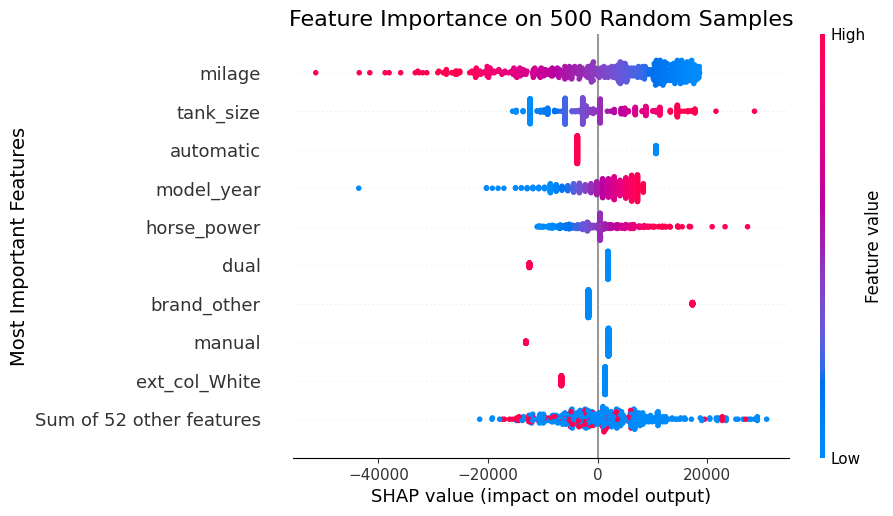

In [68]:
# Sample the training data
shap_sample = X_train.sample(500, random_state=0)

# Convert boolean columns to integers
shap_sample = shap_sample.map(lambda x: int(x) if isinstance(x, bool) else x)

# Create the SHAP explainer
explainer = shap.Explainer(linear_reg.predict, shap_sample)

# Compute SHAP values
shap_values = explainer(shap_sample)

# Plot the SHAP values
shap.plots.beeswarm(shap_values, show=False)  # Prevent the plot from being displayed immediately

# Add customizations
plt.title("Feature Importance on 500 Random Samples", fontsize=16)
plt.ylabel("Most Important Features", fontsize=14)  # Set y-axis title
plt.show()  # Display the plot

**SHAP Values on Samples with Residual Bigger than 50,000**

We aimed to investigate whether there is something we can learn from the model's mistakes by analyzing the SHAP values for samples with residuals greater than 50,000. However, since there are currently many such samples, the SHAP plots look quite similar across them, and we were unable to extract additional insights from this analysis.

PermutationExplainer explainer: 6484it [02:34, 38.81it/s]                          


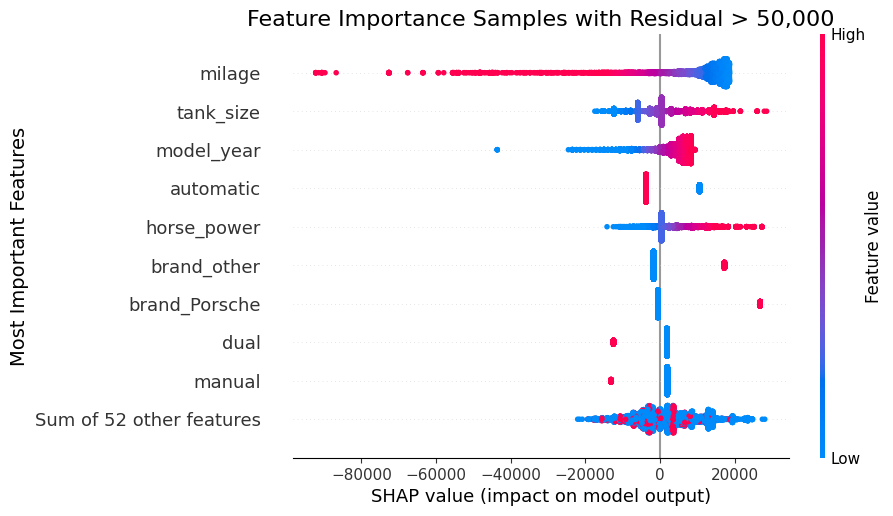

In [69]:
bad_examples = X_test.loc[residuals[residuals>50000].index]
bad_examples = bad_examples.map(lambda x: int(x) if isinstance(x, bool) else x)
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values, show=False)  # Prevent the plot from being displayed immediately

# Add customizations
plt.title("Feature Importance Samples with Residual > 50,000", fontsize=16)
plt.ylabel("Most Important Features", fontsize=14)  # Set y-axis title
plt.show()  # Display the plot

#### 4.2.7 Comparison of the Distribution of Good Estimations and Overestimations

To gain a deeper understanding of our model's mistakes, we compared the distributions of good predictions and overestimations. A good prediction was defined as one where the residual divided by the actual target value (in absolute terms) is less than 0.05.

We used histograms of mileage to illustrate this comparison. 

The plot shows that overestimations tend to occur when mileage is in the range of [0, 40,000], with around 5,000 overestimated values compared to 1,800-2,500 good estimates in this range. As mileage increases, the frequency of overestimations drops sharply. 

At higher mileage values, only overestimations are present, suggesting that the model struggles to handle these outliers effectively.

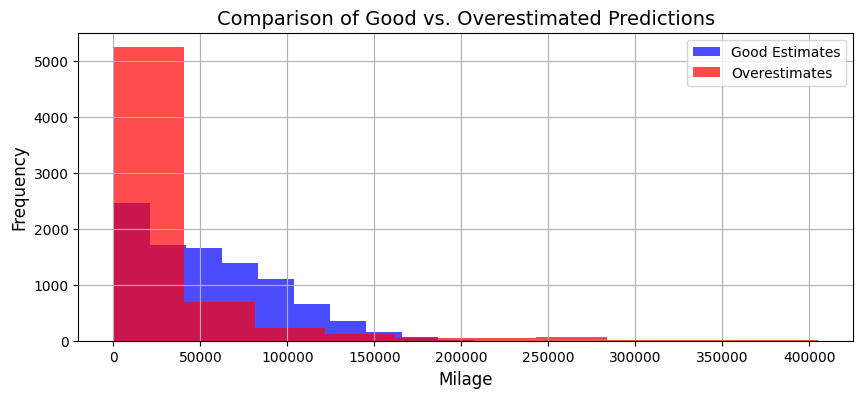

In [70]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

over_estimates = X_test.loc[residuals[residuals>50000].index]
good_estimates = X_test.loc[rel_res[rel_res<0.05].index]

fig, ax = plt.subplots(figsize=(10,4))
good_estimates.milage.hist(ax=ax,color='blue',alpha=0.7)
over_estimates.milage.hist(ax=ax,color='red', alpha=0.7)

ax.set_title('Comparison of Good vs. Overestimated Predictions', fontsize=14)
ax.set_xlabel('Milage', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(['Good Estimates', 'Overestimates'], loc='upper right')
plt.show()

#### 4.2.9 Max Error Waterfall Chart

In this section, we analyze the car with the maximum error in prediction. To do this, we used SHAP's built-in waterfall plot, which provides a clear view of how individual features influence the predicted value of the model.

The plot begins at the expected value, which represents the average prediction made by the model across all data. From there, each feature contributes either a positive or negative change to the prediction, and these contributions are shown along the y-axis. The features are listed in descending order of their impact, with the most influential features at the top.

For each feature, we see the exact amount it added or subtracted from the base prediction, visualized as a horizontal bar. The length of each bar indicates the magnitude of that feature's contribution to the final prediction. This allows us to observe which features have the largest impact, whether they increase or decrease the predicted price, and how much they deviate from the model's average expectation.

By examining the waterfall chart, we can gain valuable insights into which features are driving large prediction errors. If certain features consistently cause significant changes, it might indicate that the model is heavily relying on them, and improving the handling of these features could potentially reduce errors. This can also highlight areas where the model might be underperforming, suggesting where further adjustments or feature engineering could be beneficial to improve overall model accuracy.

In [71]:
print(f"Max Error: {max_error:,.0f}, at index {max_idx}")

# print the actual and predicted values for the row with the max error
print(f"Actual: {y_test.loc[max_idx]:,.0f}, Predicted: {y_pred[max_idx]:,.0f}")

Max Error: 2,950,944, at index 92612
Actual: 2,954,083, Predicted: 5,328


In [72]:
# Print the car with the max error
X_test.loc[max_idx]

model_year             2008
milage               132252
accident               True
clean_title            True
horse_power           272.0
                      ...  
int_col_Jet Black     False
int_col_Orange        False
int_col_Red           False
int_col_White         False
int_col_other         False
Name: 92612, Length: 61, dtype: object

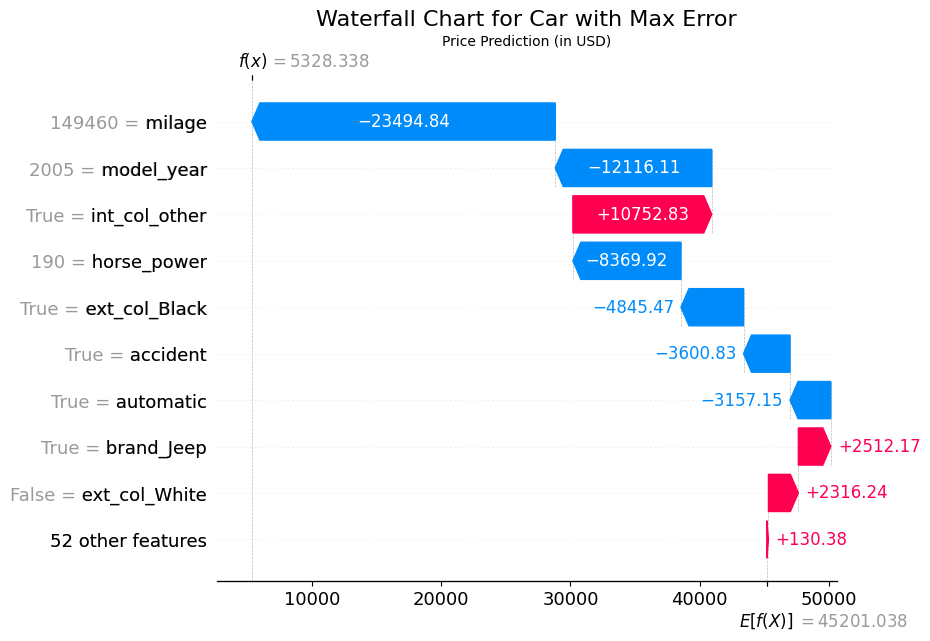

In [75]:
# Plot a waterfall chart for the row with the max error
shap.initjs()
explainer = shap.Explainer(linear_reg, X_train)
shap_values = explainer(X_test)

max_idx = residuals.idxmax()

shap_value_for_car = shap_values[max_idx]

shap.waterfall_plot(shap_value_for_car, show=False)  # Prevent the plot from being displayed immediately

# Add customizations
plt.title("Waterfall Chart for Car with Max Error", fontsize=16)

plt.xlabel("Price Prediction (in USD)")  # Set x-axis title
plt.ylabel("Most Important Features")  # Set y-axis title

plt.show()  # Display the plot

# 5. Conclusion

In the first part of this project, our goal was to predict the price of cars based on various features such as mileage, horsepower, brand, and more. Through data preprocessing, feature engineering, and model building, we explored the relationships between different features and their impact on car price predictions.

## Model Performance

Unfortunately, our model performed poorly, explaining very little of the variance in the data, with an R² score of only 0.106. This indicates that the model's predictions are far from accurate, and there is much room for improvement. Despite the low R² score, we were able to identify that features like mileage, tank size, and model year have the most significant influence on the price target.

## Next Steps

To improve the model's performance, several steps can be taken:
- **Outlier Handling**: We can try clipping outliers to prevent them from skewing the model's predictions.
- **Null Value Treatment**: Exploring alternative methods for handling missing values might help improve model accuracy.
- **Advanced Models**: Instead of relying on a simple linear regression, we can experiment with more sophisticated models, such as decision trees, random forests, or even deep learning approaches.
- **Feature Engineering**: We may also explore additional feature engineering techniques to capture more complex relationships between features and prices.

By implementing these improvements, we aim to enhance the model's ability to accurately predict car prices and provide more valuable insights for buyers, sellers, and researchers in the automotive industry.
